<a href="https://colab.research.google.com/github/claredavies/Image3DCoursework/blob/main/MatchDescriptors/MatchDescriptors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correspondence between images

Let's see step by step how an OpenCV blob detector works. Next example uses SIFT algorithm, other algorithms like SURF, FAST, ... follows the same usage pattern.

In [48]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [3]:
!git clone https://github.com/claredavies/Image3DCoursework.git

Cloning into 'Image3DCoursework'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 121 (delta 32), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (121/121), 12.04 MiB | 15.24 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [4]:
%cd Image3DCoursework/MatchDescriptors

/content/Image3DCoursework/MatchDescriptors


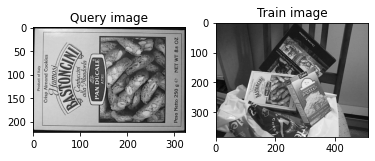

In [5]:
img1 = cv2.imread('input/box.png',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('input/box_in_scene.png',cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.title("Query image")
plt.imshow(img1, cmap="gray");

plt.subplot(1,2,2)
plt.title("Train image")
plt.imshow(img2, cmap="gray");

Let's execute the algorithm with parameters default values. Variables kp1 and kp2 will contain the detected keypoints in each images. And variables des1 and des2 will contain its descriptors.

In [6]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

In [7]:
type(kp1)

tuple

In [8]:
type(kp1[0])

cv2.KeyPoint

In [ ]:
# help(kp1[0])

In [9]:
kp1[0].pt

(3.4104702472686768, 216.3043975830078)

> Brute-force descriptor matcher. (BFMatcher)

> For each descriptor in the first set, this matcher finds the closest descriptor in the second set by trying each one. This descriptor matcher supports masking permissible matches of descriptor sets.


In [10]:
bf = cv2.BFMatcher_create()
matches = bf.knnMatch(des1, des2, k=2) # k = 2 -> Two points matching

In [11]:
type(matches)

tuple

In [12]:
matches[0]

(< cv2.DMatch 0x7f3bd8668bb0>, < cv2.DMatch 0x7f3bd86687f0>)

In [13]:
type(matches[0][0])

cv2.DMatch

In [14]:
# help(matches[0][0])

In [15]:
# Filter the most representative keypoints according to its distance (computed using KNN)
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

At the end OpenCV have a function to ease the visual representation of the detected and selected keypoints.

[Drawing keypoints and matches documentation](https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html)

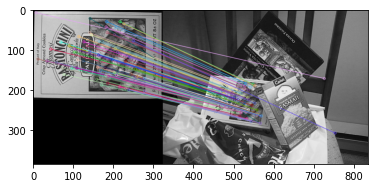

In [16]:
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3);

## Interesting links

* https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html 

* https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html

## Homework

1. Construct the panoramic view of the next two images using four points manually selected.
2. Try out several descriptors you have seen in theory classes (Harris, SIFT, SURF, ...)
3. Construct the panoramic view of the next two images using the keypoints obtained with the previous algorithms.

### Read the images

Once we have imported the required libraries, we are going to load two images from the same building for the aim to do a panoramic view. 
We read both images and convert it to grayscale. We don't override colour images as we are going to use it for pretty visualisation.

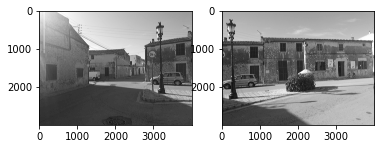

In [17]:
img1 = cv2.imread("input/edifici1.jpg")
img2 = cv2.imread("input/edifici2.jpg")

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plt.subplot(1,2,1)
plt.imshow(img1_gray, cmap="gray");

plt.subplot(1,2,2)
plt.imshow(img2_gray, cmap="gray");

### Exercise 1

Select four keypoints manually:

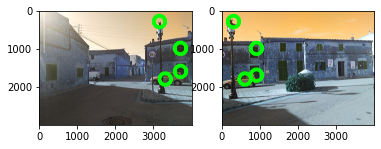

In [118]:
debug_img1 = img1.copy()
debug_img2 = img2.copy()

points = [ 
    [[3150,300],[300,300]], [[3300, 1800],[600, 1800]], [[3700, 1600],[900, 1700]], [[3700, 1000],[900, 1000]]
]

for pt1, pt2 in points:
    # print("point1: " + str(pt1))
    # print("point2: " + str(pt2))

    cv2.circle(debug_img1, (int(pt1[0]), int(pt1[1])), 150, (0, 255, 0), 100)
    cv2.circle(debug_img2, (int(pt2[0]), int(pt2[1])), 150, (0, 255, 0), 100)


plt.subplot(1,2,1)
plt.imshow(debug_img1);

plt.subplot(1,2,2)
plt.imshow(debug_img2);  

#### Homography
Once we have the 4 correspondent points let's do the homography of both images
* https://learnopencv.com/homography-examples-using-opencv-python-c/

In [119]:
src, dst = zip(*points)

In [120]:
src = np.float32(src).reshape(-1,1,2)
dst = np.float32(dst).reshape(-1,1,2)

In [122]:
# TODO:  cv2.findHomography
M, mask = cv2.findHomography(src, dst, cv2.RANSAC,5.0)

## *Warp* images
Finally, we convert the destination images to the origin image plane.

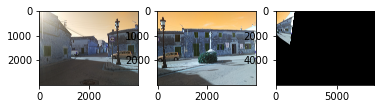

In [129]:
# TODO:  cv2.warpPerspective
im_out = cv2.warpPerspective(img2, M, (img1.shape[1] * 2, img1.shape[0] * 2))

plt.subplot(1,3,1)
plt.imshow(img1, cmap="gray");

plt.subplot(1,3,2)
plt.imshow(img2, cmap="gray");

plt.subplot(1,3,3)
plt.imshow(im_out, cmap="gray");
# plt.show()

### Exercise 2

### Select a descriptor

In the next cell you must initialize a descriptor object (different of SIFT) as we have done previously:
```{python}
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
```

### Extract keys and descriptors

Extract keys and descriptors using OpenCV *common* module

In [ ]:
# find the keypoints and descriptors with SIFT
kp1, des1 = ...
kp2, des2 = ...

With the descriptors obtained in this step let's perform a correspondence operation and a filtering one.

### Exercise 3

In [ ]:
# BFMatcher with default params
bf = ...
matches = ...

# TODO: Apply ratio test


# TODO: cv.drawMatchesKnn or equivalent function


### Homography

With the previously obtained correspondences, we can perform an homography between both images.

* https://learnopencv.com/homography-examples-using-opencv-python-c/

In [ ]:
src = ...
dst = ...


In [ ]:
# TODO:  cv2.findHomography

## *Warp* images

Finally transform the destination image to the origin image plane.

In [ ]:
# TODO: cv2.warpPerspective